In [2]:
import logging
%load_ext autoreload
%autoreload 2

import torch
import os
import random
import logging

import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn

from torch.utils.data import DataLoader
from diveslowlearnfast.datasets import Diving48Dataset
from diveslowlearnfast.egl.explainer import ExplainerStrategy
from diveslowlearnfast.train.helper import get_test_transform
from diveslowlearnfast.models import SlowFast, load_checkpoint
from diveslowlearnfast.config import Config
from diveslowlearnfast.visualise.gradcam import GradCAM
from diveslowlearnfast.visualise.create_heatmap import create_heatmaps
from diveslowlearnfast.train import helper as train_helper, StatsDB
from diveslowlearnfast.egl import helper as egl_helper
from diveslowlearnfast.egl.generate_masks import _generate_masks
from diveslowlearnfast.loss.rrr import RRRLoss, DualPathRRRLoss
from diveslowlearnfast.models.utils import to_slowfast_inputs
from diveslowlearnfast.egl import run_egl_train_epoch

import torch.nn.functional as F

cfg = Config()
cfg.DATA.DATASET_PATH = '/Users/youritomassen/Projects/xai/data/Diving48/'
cfg.TRAIN.BATCH_SIZE = 2
cfg.GRADCAM.TARGET_LAYERS = ['s5/pathway0_res2', 's5/pathway1_res2']
device = torch.device('cpu')
model = SlowFast(cfg)
_, optimiser, *_ = train_helper.get_train_objects(cfg, model, device)
model, *_ = load_checkpoint(model, '../misc/checkpoint.pth', optimiser, device)
explainer = ExplainerStrategy.get_explainer(model, cfg=cfg, device=device)

stats_db = StatsDB('./data/stats.db')
difficult_samples = stats_db.get_below_median_samples(
    epoch_start=90,
    run_id='/home/s2871513/Projects/diveslowlearnfast/results/run18',
    split='train'
)

video_ids = list(map(lambda x: x[0], difficult_samples))

train_dataset = Diving48Dataset(
    cfg.DATA.DATASET_PATH,
    cfg.DATA.NUM_FRAMES,
    dataset_type='train',
    transform_fn=get_test_transform(cfg),  # use test_transform instead
    use_decord=cfg.DATA_LOADER.USE_DECORD,
    temporal_random_jitter=cfg.DATA.TEMPORAL_RANDOM_JITTER,
    temporal_random_offset=cfg.DATA.TEMPORAL_RANDOM_OFFSET,
    multi_thread_decode=cfg.DATA.MULTI_THREAD_DECODE,
    threshold=cfg.DATA.THRESHOLD,
    use_sampling_ratio=cfg.DATA.USE_SAMPLING_RATIO,
    video_ids=video_ids
)

train_loader = DataLoader(
    train_dataset,
    batch_size=cfg.TRAIN.BATCH_SIZE,
    pin_memory=cfg.DATA_LOADER.PIN_MEMORY,
    num_workers=cfg.DATA_LOADER.NUM_WORKERS,
    shuffle=True,
)

In [12]:
xb, yb, *_ = next(iter(train_loader))

In [26]:
inputs = to_slowfast_inputs(xb, alpha=cfg.SLOWFAST.ALPHA)
localisation_maps, _logits = explainer(inputs, yb)

activations tensor(0.1934)
activations tensor(0.0457)
gradient  tensor(-1.6824e-10)
gradient  tensor(-3.1719e-10)


In [28]:
inputs = to_slowfast_inputs(xb, alpha=cfg.SLOWFAST.ALPHA)
localisation_maps, _logits = explainer(inputs, yb)

activations tensor(0.1693)
activations tensor(0.0425)
gradient  tensor(-1.6824e-10)
gradient  tensor(-3.1719e-10)


In [150]:
heatmaps = create_heatmaps(inputs, localisation_maps, mean=cfg.DATA.MEAN, std=cfg.DATA.STD)

In [151]:
html, ani = jupyter_video.vidshow(heatmaps[0][0], title='Slow Video', interval=240, axis='off')
plt.close('all')
html

HTML(value='\n<link rel="stylesheet"\nhref="https://maxcdn.bootstrapcdn.com/font-awesome/4.4.0/css/font-awesom…

In [152]:
slow_frame1 = heatmaps[0][1][1]
fast_frame1 = heatmaps[1][0][16]

In [153]:
heatmaps[0].shape

torch.Size([2, 4, 3, 256, 256])

In [154]:
slow_frame_tensor = heatmaps[0].permute(0, 2, 1, 3, 4)
B, C, T, H, W = slow_frame_tensor.shape
output_size = (T * cfg.SLOWFAST.ALPHA, H, W)

In [155]:
slow_frame_tensor.shape, output_size

(torch.Size([2, 3, 4, 256, 256]), (32, 256, 256))

In [156]:
slow_inter = F.interpolate(slow_frame_tensor, output_size)
slow_inter.shape

torch.Size([2, 3, 32, 256, 256])

In [157]:
slow_frame1.shape

torch.Size([3, 256, 256])

In [158]:
heatmaps[0].shape

torch.Size([2, 4, 3, 256, 256])

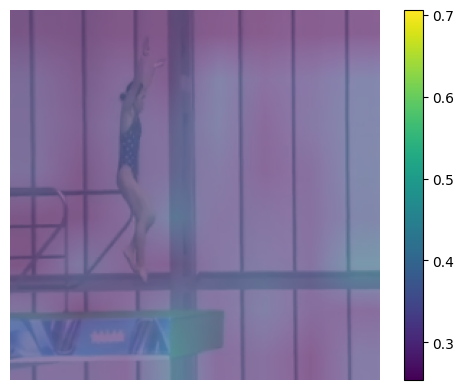

In [176]:
plt.imshow(heatmaps[1][0][1].numpy().transpose(1, 2, 0))
plt.axis('off')
plt.colorbar()
plt.show()

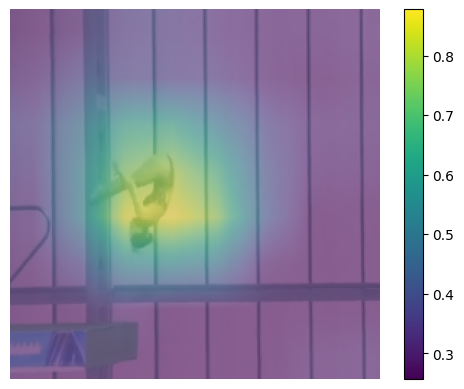

In [187]:
plt.imshow(slow_inter[0].numpy().transpose(1, 2, 3, 0)[7])
plt.axis('off')
plt.colorbar()
plt.show()

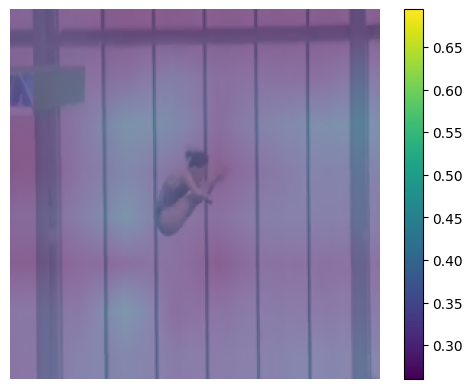

In [177]:
plt.imshow(fast_frame1.numpy().transpose(1, 2, 0))
plt.axis('off')
plt.colorbar()
plt.show()

In [16]:
localisation_maps[0].shape, localisation_maps[1].shape

(torch.Size([2, 1, 4, 256, 256]), torch.Size([2, 1, 32, 256, 256]))

In [17]:
_, _, T, H, W = localisation_maps[1].shape
output_size = (T, H, W)
localisation_map_slow_inter = F.interpolate(localisation_maps[0], output_size)
localisation_map_slow_inter.shape, output_size

(torch.Size([2, 1, 32, 256, 256]), (32, 256, 256))

In [18]:
alpha = .5

fused_maps = localisation_maps[1] + localisation_map_slow_inter

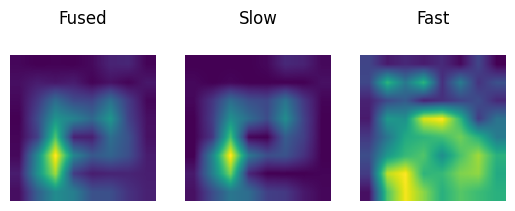

(None, tensor(165019.9688), tensor(25862.3359))

In [19]:
idx = 31

plt.tight_layout()

ax = plt.subplot(131)
ax.matshow(fused_maps[0][0][idx].numpy())
ax.set_title('Fused')
ax.axis('off')

ax = plt.subplot(132)
ax.matshow(localisation_map_slow_inter[0][0][idx].numpy())
ax.set_title('Slow')
ax.axis('off')

ax = plt.subplot(133)
ax.matshow(localisation_maps[1][0][0][idx].numpy())
ax.set_title('Fast')
ax.axis('off')
plt.show(), localisation_maps[1][0][0].sum(), localisation_maps[0][0][0].sum()

# Create a two path RRR Loss
Motivation: the single path RRR Loss does not account for the different attribution maps created for the slow fast network.
Using the attribution map of the slow path for both pathways as we do now does not give a fair representation of the loss. Instead we should
use these heatmaps create binary masks that encourage gradients in the inverted binary mask of these attribution maps.

In the upcoming section we'll develop a RRR Loss method that takes both of these pathways into account.

## Alternative optimisation
Take the gradient panalty for time step t to be t-1. This way we can take the gradient that has been calculated during the backward pass.

In [6]:
def threshold(features):
    thresh = np.percentile(features, 50, axis=(1, 2))
    thresh = thresh.reshape((-1, 1, 1))
    filtered = features > thresh
    return filtered


idx = 31

plt.tight_layout()

features = fused_maps[0][0].numpy()
mask = threshold(features)
ax = plt.subplot(131)
ax.imshow(~mask[idx], cmap='gray')
ax.set_title('Fused')
ax.axis('off')

features = localisation_map_slow_inter[0][0]
mask = threshold(features.numpy())
ax = plt.subplot(132)
ax.imshow(~mask[idx], cmap='gray')
ax.set_title('Slow')
ax.axis('off')

features = localisation_maps[1][0][0].numpy()
mask = threshold(features)
ax = plt.subplot(133)
ax.imshow(~mask[idx], cmap='gray')
ax.set_title('Fast')
ax.axis('off')
plt.show()

NameError: name 'fused_maps' is not defined

<Figure size 640x480 with 0 Axes>

In [78]:
def r3_loss(logits, targets, inputs, masks):
    """
    Compute the RRR loss.

    Args:
        logits: Model output logits (B x num_classes)
        targets: Ground truth labels (B)
        model: The model being trained
        inputs: Input data (B x ...)
        masks: Binary masks indicating where gradients should be small (B x ...)

    Returns:
        total_loss: Combined loss value
        losses: Dictionary containing individual loss components
    """
    ce_loss = torch.nn.CrossEntropyLoss()(logits, targets)
    # boolean mask to select indices for which there is a mask available
    # this little optimisation ensures that we do not use autograd on inputs that will
    # be ignored anyway
    mask = (masks[0].sum(dim=(1, 2, 3, 4)) > 0)
    masked_elements = inputs[0][mask]
    total_loss = ce_loss
    if masked_elements.shape[0] > 0:
        log_probs = F.softmax(logits, dim=1)
        summed_log_probs = log_probs.sum()
        xb_slow = inputs[0]
        xb_fast = inputs[1]
        gradients_slow = torch.autograd.grad(summed_log_probs, xb_slow, create_graph=True, retain_graph=True)[0]
        gradients_fast = torch.autograd.grad(summed_log_probs, xb_fast, create_graph=True, retain_graph=True)[0]
        gradient_slow_loss = (masks[0] * gradients_slow).pow(2).mean()
        gradient_fast_loss = (masks[1] * gradients_fast).pow(2).mean()

        total_loss += 1000.0 + gradient_slow_loss + 1000.0 * gradient_fast_loss
        gradient_slow_loss_item = gradient_slow_loss.item()
        gradient_fast_loss_item = gradient_fast_loss.item()
    else:
        gradient_loss = 0
        gradient_slow_loss_item = gradient_loss
        gradient_fast_loss_item = gradient_loss

    losses = {
        'total_loss': total_loss.item(),
        'ce_loss': ce_loss.item(),
        'gradient_slow_loss': gradient_slow_loss_item,
        'gradient_fast_loss': gradient_fast_loss_item
    }

    return total_loss, losses

In [22]:
xb, yb, *_ = next(iter(train_loader))

In [23]:
xb_fast = xb[:].to(device)
# reduce the number of frames by the alpha ratio
# B x C x T / alpha x H x W
xb_slow = xb[:, :, ::cfg.SLOWFAST.ALPHA].to(device)
inputs = [xb_slow, xb_fast]

heatmaps = create_heatmaps(inputs, localisation_maps, mean=cfg.DATA.MEAN, std=cfg.DATA.STD)

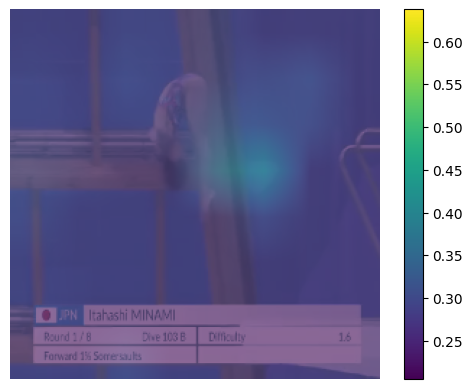

In [24]:
plt.imshow(heatmaps[0][0][0].numpy().transpose(1, 2, 0))
plt.axis('off')
plt.colorbar()
plt.show()

In [25]:
localisation_maps[0].shape, localisation_maps[1].shape

(torch.Size([2, 1, 4, 256, 256]), torch.Size([2, 1, 32, 256, 256]))

In [26]:
masks_slow = _generate_masks(localisation_maps[0])
masks_fast = _generate_masks(localisation_maps[1])
masks_slow.shape, masks_fast.shape

((2, 1, 4, 256, 256), (2, 1, 32, 256, 256))

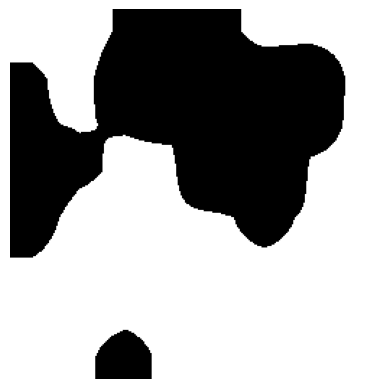

In [27]:
plt.imshow(masks_slow[0][0][0], cmap='gray')
plt.axis('off')
plt.show()

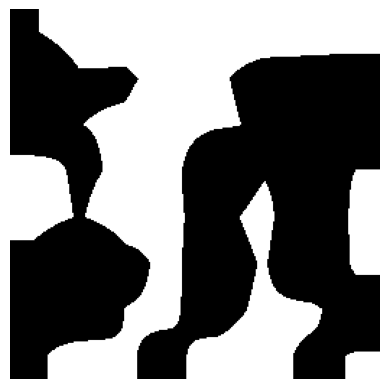

In [28]:
plt.imshow(masks_fast[0][0][0], cmap='gray')
plt.axis('off')
plt.show()

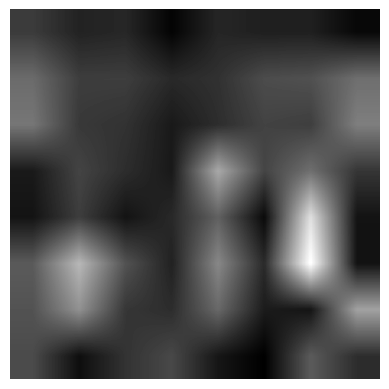

In [29]:
plt.imshow(localisation_maps[1][0][0][0], cmap='gray')
plt.axis('off')
plt.show()

In [66]:
xb, yb, *_ = next(iter(train_loader))

In [67]:
xb_fast = xb[:].to(device)
# reduce the number of frames by the alpha ratio
# B x C x T / alpha x H x W
xb_slow = xb[:, :, ::cfg.SLOWFAST.ALPHA].to(device)
xb_fast.requires_grad = True
xb_slow.requires_grad = True

inputs = [xb_slow, xb_fast]
logits = model(inputs)
# localisation_maps = explainer(xb, yb)

/Users/youritomassen/Projects/Uni/Master Thesis/diveslowlearnfast/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


In [68]:
masks = _generate_masks(localisation_maps[1])

_, losses = RRRLoss()(logits, yb, xb_fast, torch.from_numpy(masks))
losses

{'total_loss': 2.937316417694092,
 'ce_loss': 2.937316417694092,
 'gradient_loss': 2.7703192617648204e-27}

In [69]:
masks = _generate_masks(localisation_maps[0])
_, losses = RRRLoss()(logits, yb, xb_slow, torch.from_numpy(masks))
losses

{'total_loss': 2.937316417694092,
 'ce_loss': 2.937316417694092,
 'gradient_loss': 5.980550582148829e-27}

In [80]:
_, losses = r3_loss(logits, yb, inputs, [
    torch.from_numpy(_generate_masks(localisation_maps[0])), torch.from_numpy(_generate_masks(localisation_maps[1]))])

losses

{'total_loss': 1002.9373168945312,
 'ce_loss': 1002.9373168945312,
 'gradient_slow_loss': 5.980550582148829e-27,
 'gradient_fast_loss': 2.7703192617648204e-27}

In [84]:
xb_slow.requires_grad, xb_slow[0].requires_grad,

(True, True, True)

In [107]:
xb, *_ = next(iter(train_loader))

In [124]:
xb_fast = xb[:].to(device)
# reduce the number of frames by the alpha ratio
# B x C x T / alpha x H x W
xb_slow = xb[:, :, ::cfg.SLOWFAST.ALPHA].to(device)
xb_fast.requires_grad = True
xb_slow.requires_grad = True

inputs = [xb_slow, xb_fast]
logits = model(inputs)
logits

tensor([[9.7643e-07, 5.6352e-07, 2.7379e-07, 3.9355e-08, 9.4547e-09, 1.1603e-04,
         2.3480e-07, 2.6494e-05, 6.1036e-07, 4.3171e-05, 4.4095e-07, 7.3422e-08,
         2.8759e-07, 1.6047e-07, 6.4509e-07, 4.4626e-08, 4.2118e-10, 8.3720e-05,
         5.9635e-07, 5.3043e-06, 4.3264e-08, 9.4288e-01, 5.1542e-05, 1.2467e-05,
         2.9614e-02, 6.5565e-06, 2.7130e-02, 1.0427e-05, 1.4657e-06, 2.2868e-06,
         2.7259e-09, 4.0048e-09, 2.6304e-09, 5.0881e-06, 3.5748e-08, 4.7359e-08,
         7.9178e-08, 1.0275e-07, 2.8611e-07, 3.9333e-08, 7.6590e-09, 1.6333e-07,
         3.3066e-08, 7.5531e-07, 1.0775e-06, 5.9571e-09, 2.8648e-06, 2.7850e-08],
        [1.2614e-11, 1.2394e-08, 4.5497e-07, 8.2705e-13, 1.9112e-12, 1.9488e-07,
         1.9947e-08, 6.2547e-09, 1.0227e-10, 2.5915e-09, 1.2162e-07, 4.9161e-12,
         6.8869e-11, 9.0995e-12, 2.3198e-12, 3.7986e-10, 4.1085e-13, 1.6147e-08,
         1.5317e-08, 9.3415e-10, 5.2776e-13, 7.8489e-01, 2.1510e-01, 7.3718e-06,
         6.8366e-10, 1.4298

In [125]:
bool_mask = [True, False]
relevant_inputs = xb_slow[bool_mask]
relevant_logits = logits[bool_mask]
loss = F.cross_entropy(relevant_logits, yb[bool_mask])
grads = torch.autograd.grad(loss, xb_slow, retain_graph=True, create_graph=True)[0]

In [126]:
grads[0].sum(),

(tensor(-0.0024, grad_fn=<SumBackward0>),)

## DualPathRRRLoss
The `DualPathRRRLoss` supports both the slow and the fast component inputs to the slow fast network.
The major change compared to the original RRRLoss is that the inputs and masks are now arrays. Where the
first elements of the respective arrays contain the slow inputs and masks, and the second contain the fast
input and mask. It returns the total loss and a map containing the individual loss components. Again the
slow and fast component will be indexed by '0' and '1' respectively.

First let us explore the influence of $\lambda$ on the loss. Let's start with a value of 1000.0.

In [188]:
def masks_creator_from_explainer(explainer):
    def _inner(x, y):
        localisation_maps, logits = explainer(inputs, yb)
        return [torch.from_numpy(_generate_masks(map)) for map in localisation_maps], logits

    return _inner


In [189]:
create_masks = masks_creator_from_explainer(explainer)

In [124]:
dualpath_rrr = DualPathRRRLoss(lambdas=[1000.0, 1000.0])

In [110]:
xb, yb, *_ = next(iter(train_loader))

In [125]:
inputs = to_slowfast_inputs(
    xb,
    alpha=cfg.SLOWFAST.ALPHA,
    requires_grad=True
)
masks, _ = create_masks(inputs, yb)

/Users/youritomassen/Projects/Uni/Master Thesis/diveslowlearnfast/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


In [126]:
inputs = to_slowfast_inputs(
    xb,
    alpha=cfg.SLOWFAST.ALPHA,
    requires_grad=True
)
logits = model(inputs, yb)

In [127]:
inputs[0].grad is None

True

Running the next cell will show that with a $\lambda = 1000.0$ it will be in the $1.0e-7$ magnitude, meaning it as negligible influence on the total loss. Thus we have to increase it's value.

In [128]:
loss, individual_losses = dualpath_rrr(logits, yb, inputs, masks)
individual_losses

{'ce_loss': 2.917043685913086,
 'gradient_loss_path_0': 1.7439360533444415e-07,
 'gradient_loss_path_1': 7.883677994868776e-07,
 'total_loss': 2.9170446395874023}

If we want gradient losses in the same magnitude range as the ce loss we can adjust lambda. Since, a lambda of 1000.0 will produce gradients in the 1e-7 we should increase to about 1e12.

In [197]:
# gradients from the summed log probabilities
rrr_loss = DualPathRRRLoss(lambdas=[1.0e9, 0.5e11], force_new_gradients=True)
inputs = to_slowfast_inputs(
    xb,
    alpha=cfg.SLOWFAST.ALPHA,
    requires_grad=True
)
masks, _ = explainer(inputs, yb)
# model.zero_grad() will still reuse the gradients on the input
model.zero_grad()
logits = model(inputs, yb)
_, individual_losses = rrr_loss(logits, yb, inputs, masks)
individual_losses

{'ce_loss': 2.9207921028137207,
 'gradient_loss_path_0': 1.0290265083312988,
 'gradient_loss_path_1': 3.1021854877471924,
 'total_loss': 7.052003860473633}

### Normalised Gradients
One way to get improve our gradient loss for the slow and fast path is to normalise the gradients. Here we get quiet large values, which means we should lower lambda if we opt to use this method.

In [194]:
rrr_norm_grads = DualPathRRRLoss(lambdas=[1000.0, 1000.0], normalise_gradients=True)
inputs = to_slowfast_inputs(
    xb,
    alpha=cfg.SLOWFAST.ALPHA,
    requires_grad=True
)
masks, logits = create_masks(inputs, yb)
_, individual_losses = rrr_norm_grads(logits, yb, inputs, masks)
individual_losses

{'ce_loss': 2.9207921028137207,
 'gradient_loss_path_0': 1219.7554931640625,
 'gradient_loss_path_1': 4984.52001953125,
 'total_loss': 6207.1962890625}

### Reusing Gradients from creating masks
The DualPathRRRLoss supports gradients that have been obtained through a backward pass when creating the localisation map. And gradients that have been created with respect to the summed log probs.

In [198]:
# Gradients from GradCAM
rrr_loss = DualPathRRRLoss(normalise_gradients=False)
inputs = to_slowfast_inputs(
    xb,
    alpha=cfg.SLOWFAST.ALPHA,
    requires_grad=True
)
masks, logits = create_masks(inputs, yb)
_, individual_losses = rrr_loss(logits, yb, inputs, masks)
individual_losses

{'ce_loss': 2.9207921028137207,
 'gradient_loss_path_0': 87.24501037597656,
 'gradient_loss_path_1': 103.61883544921875,
 'total_loss': 193.78463745117188}

## Testing Gradient Stability
In this section the gradient stability is tested for stability


In [29]:
cfg.TRAIN.BATCH_SIZE = 8
cfg.TRAIN.NUM_WORKERS = 1
train_loader = DataLoader(
    train_dataset,
    batch_size=cfg.TRAIN.BATCH_SIZE,
    pin_memory=cfg.DATA_LOADER.PIN_MEMORY,
    num_workers=cfg.DATA_LOADER.NUM_WORKERS,
    shuffle=True,
)
train_loader = iter(train_loader)

PicklingError: Can't pickle <function load_video_av_optimized at 0x12b3c4ea0>: it's not the same object as diveslowlearnfast.datasets.diving48.load_video_av_optimized

In [202]:
from tqdm import tqdm

rrr_loss = DualPathRRRLoss(
    lambdas=[0.5e10, 0.5e11],
    force_new_gradients=True
)
loss_history = []
# run for 30 batches
for idx in tqdm(range(50)):
    xb, yb, *_ = next(train_loader)
    inputs = to_slowfast_inputs(
        xb,
        alpha=cfg.SLOWFAST.ALPHA,
        requires_grad=True
    )
    masks, logits = create_masks(inputs, yb)
    model.zero_grad()
    _, individual_losses = rrr_norm_grads(logits, yb, inputs, masks)
    loss_history.append(individual_losses)

  0%|          | 0/50 [00:00<?, ?it/s]/Users/youritomassen/Projects/Uni/Master Thesis/diveslowlearnfast/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)
100%|██████████| 50/50 [45:36<00:00, 54.73s/it] 


In [209]:
import pandas as pd

df = pd.DataFrame(loss_history)
df.head(5)

,ce_loss,gradient_loss_path_0,gradient_loss_path_1,total_loss
0,2.920730,4352.138672,836.086121,5191.145508
1,3.013066,2104.077881,1036.862305,3143.953369
2,3.182981,3866.219238,1500.602661,5370.004883
3,2.944367,7093.719238,3798.430908,10895.094727
4,2.928539,1293.945679,467.933472,1764.807739


In [210]:
(df / 1000).var()

ce_loss                 7.659542e-09
gradient_loss_path_0    1.740676e+02
gradient_loss_path_1    2.164535e+01
total_loss              2.756192e+02
dtype: float64

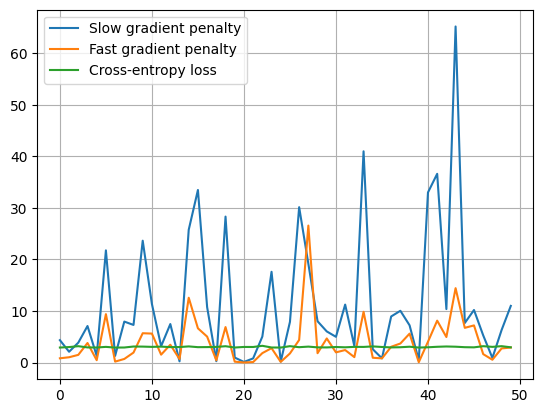

In [211]:
plt.plot(df['gradient_loss_path_0'] / 1000, label='Slow gradient penalty')
plt.plot(df['gradient_loss_path_1'] / 1000, label='Fast gradient penalty')
plt.plot(df['ce_loss'], label='Cross-entropy loss')
plt.legend()
plt.grid()
plt.show()

### Updating and Testing `generate_masks`
We should update the `generate_masks` function to generate masks for the slow and the fast path. To this end, we need to create to masks caches:
1. `.masks/slow`: slow path masks go here
2. `.masks/fast`: and ofcourse the fast pathway masks go here.

In [2]:
cfg.TRAIN.BATCH_SIZE = 8
cfg.DATA_LOADER.NUM_WORKERS = 1
cfg.EGL.MASKS_CACHE_DIR = './.masks'
cfg.DATA.TEST_CROP_SIZE = 224
train_dataset = Diving48Dataset(
    cfg.DATA.DATASET_PATH,
    cfg.DATA.NUM_FRAMES,
    dataset_type='train',
    transform_fn=get_test_transform(cfg),  # use test_transform instead
    use_decord=cfg.DATA_LOADER.USE_DECORD,
    temporal_random_jitter=cfg.DATA.TEMPORAL_RANDOM_JITTER,
    temporal_random_offset=cfg.DATA.TEMPORAL_RANDOM_OFFSET,
    multi_thread_decode=cfg.DATA.MULTI_THREAD_DECODE,
    threshold=cfg.DATA.THRESHOLD,
    use_sampling_ratio=cfg.DATA.USE_SAMPLING_RATIO,
    video_ids=list(map(lambda x: x[0], difficult_samples)),
    masks_cache_dir=cfg.EGL.MASKS_CACHE_DIR,
)

train_loader = DataLoader(
    train_dataset,
    batch_size=cfg.TRAIN.BATCH_SIZE,
    pin_memory=cfg.DATA_LOADER.PIN_MEMORY,
    num_workers=cfg.DATA_LOADER.NUM_WORKERS,
    shuffle=True,
)

In [20]:
egl_helper.purge_masks_cache(cfg.EGL.MASKS_CACHE_DIR)
egl_helper.generate_masks(train_loader, explainer, cfg)

Generating masks:   1%|          | 3/393 [01:24<3:02:01, 28.00s/it]


KeyboardInterrupt: 

In [3]:
slow_masks_dir = os.path.join(cfg.EGL.MASKS_CACHE_DIR, 'slow')
fast_masks_dir = os.path.join(cfg.EGL.MASKS_CACHE_DIR, 'fast')

assert os.path.exists(slow_masks_dir)
assert os.path.exists(fast_masks_dir)

assert len(os.listdir(slow_masks_dir)) > 0
assert len(os.listdir(fast_masks_dir)) > 0

### Update Diving48Dataset for Dual Path Masks
Now that we are caching dual path masks, we should also update the `Diving48Dataset`.

In [4]:
mask_npys = os.listdir(slow_masks_dir)
video_ids = list(map(lambda x: x.replace('.npy', ''), mask_npys))
video_ids[:5]

['JzOshOJgofw_00176',
 'nOlRwoxsDJ0_00609',
 'db7DmpqzGmc_00121',
 'RWNrARSbRCY_00021',
 'iv0Gu1VXAgc_00067']

In [8]:
cfg.DATA.TEST_CROP_SIZE = 224
diving48 = Diving48Dataset(
    cfg.DATA.DATASET_PATH,
    cfg.DATA.NUM_FRAMES,
    dataset_type='train',
    transform_fn=get_test_transform(cfg),  # use test_transform instead
    use_decord=cfg.DATA_LOADER.USE_DECORD,
    temporal_random_jitter=cfg.DATA.TEMPORAL_RANDOM_JITTER,
    temporal_random_offset=cfg.DATA.TEMPORAL_RANDOM_OFFSET,
    multi_thread_decode=cfg.DATA.MULTI_THREAD_DECODE,
    threshold=cfg.DATA.THRESHOLD,
    use_sampling_ratio=cfg.DATA.USE_SAMPLING_RATIO,
    video_ids=video_ids,
    masks_cache_dir=cfg.EGL.MASKS_CACHE_DIR,
)

len(diving48)

24

In [9]:
video, label, _io_time, _transform_time, video_id, slow_mask, fast_mask = diving48.__getitem__(0)

video.shape, slow_mask.shape, fast_mask.shape

(torch.Size([3, 32, 224, 224]),
 (1, 4, 224, 224),
 (1, 32, 224, 224),
 100366,
 802818)

### Validating `run_egl_train_epoch`
This method runs an egl train epoch using a RRRLoss function. To validate this we are going to create a dataset that is limited to the contents of the `.masks/..` cache dir.

Furthermore, we should investigate if the RRRLoss function works on samples that don't have a mask.

In [6]:
cfg.TRAIN.BATCH_SIZE = 4
cfg.RRR.LAMBDAS = [0.5e7, 0.5e8]
cfg.EGL.ENABLED = True
cfg.TRAIN.MACRO_BATCH_SIZE = 8
rrr_loss, optimiser, loader, dataset, _ = train_helper.get_train_objects(
    cfg,
    model,
    device,
    video_ids
)

stats_db = StatsDB('./stats.db')
epoch = 1
len(dataset), rrr_loss

(24,
 DualPathRRRLoss(
   (cross_entropy): CrossEntropyLoss()
 ))

In [26]:

result = run_egl_train_epoch(
    model,
    rrr_loss,
    optimiser,
    loader,
    device,
    cfg,
    stats_db,
    epoch
)

Train EGL batch: 100%|██████████| 6/6 [02:50<00:00, 28.47s/it, current_batch_time=31.451, current_io_time=0.097, current_transform_time=0.097, current_loss=0.338, current_accuracy=0.417]


In [7]:
non_mask_video_ids = list(map(lambda x: x[0], difficult_samples))
non_mask_video_ids = random.sample(non_mask_video_ids, 24)

mask_and_non_mask_video_ids = list(set(video_ids + non_mask_video_ids))
len(mask_and_non_mask_video_ids)

48

In [16]:
cfg.TRAIN.BATCH_SIZE = 4
cfg.RRR.LAMBDAS = [0.5e7, 0.5e8]
cfg.EGL.ENABLED = True
cfg.TRAIN.MACRO_BATCH_SIZE = 8
rrr_loss, optimiser, loader, dataset, _ = train_helper.get_train_objects(
    cfg,
    model,
    device,
    mask_and_non_mask_video_ids
)

stats_db = StatsDB('./stats.db')
epoch = 1
len(dataset), rrr_loss

NameError: name 'mask_and_non_mask_video_ids' is not defined

In [31]:
video, _, _, _, _, slow_mask, fast_mask = dataset.__getitem__(0)

slow_mask.shape[1] // 8, fast_mask.shape[1]

(4, 4)

In [36]:
for idx in range(len(dataset)):
    _, _, _, _, _, slow_mask, fast_mask = dataset.__getitem__(idx)
    Ts = slow_mask.shape[1]
    Tf = fast_mask.shape[1]
    assert Tf // cfg.SLOWFAST.ALPHA == Ts, f'idx = {idx}, Tf = {Tf} Ts = {Ts} slow_mask_size = {np.sum(slow_mask)} fast_mask_size = {np.sum(fast_mask)}'


In [9]:
result = run_egl_train_epoch(
    model,
    rrr_loss,
    optimiser,
    loader,
    device,
    cfg,
    stats_db,
    epoch
)

result

Train EGL batch:   0%|          | 0/12 [00:00<?, ?it/s]/Users/youritomassen/Projects/Uni/Master Thesis/diveslowlearnfast/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)
Train EGL batch: 100%|██████████| 12/12 [05:15<00:00, 26.26s/it, current_batch_time=25.045, current_io_time=0.148, current_transform_time=0.097, current_loss=3.906, current_accuracy=0.000]


(0.125, 3.7779493927955627)

## Optimised RRRLoss
Let's now create an OptimisedDualPathRRRLoss. This loss function filters masks by only calculating the gradient with respect to the input based on masks
that are non-zero. The goal is to speed up computation, when running this mode, since we are often only running with 5% of the data that actually has a mask.

### Data preparation
We create three datasets:

1. will have 8 non zero masks
2. a dataset with 1 non-zero mask and 7 zero masks.
3. and all non zero masks

This is to test the efficiency gain.

In [5]:
cfg.EGL.MASKS_CACHE_DIR = './.masks'
slow_masks_dir = os.path.join(cfg.EGL.MASKS_CACHE_DIR, 'slow')
non_mask_video_ids = list(map(lambda x: x[0], difficult_samples))[:8]
mask_npys = os.listdir(slow_masks_dir)
masked_video_ids = list(map(lambda x: x.replace('.npy', ''), mask_npys))[:8]
mixed_video_ids = masked_video_ids[:1] + non_mask_video_ids[:7]


def get_batch(video_ids=None):
    cfg.DATA.TEST_CROP_SIZE = 224
    dataset = Diving48Dataset(
        cfg.DATA.DATASET_PATH,
        cfg.DATA.NUM_FRAMES,
        alpha=cfg.SLOWFAST.ALPHA,
        dataset_type='train',
        transform_fn=get_test_transform(cfg),  # use test_transform instead
        use_decord=cfg.DATA_LOADER.USE_DECORD,
        temporal_random_jitter=cfg.DATA.TEMPORAL_RANDOM_JITTER,
        temporal_random_offset=cfg.DATA.TEMPORAL_RANDOM_OFFSET,
        multi_thread_decode=cfg.DATA.MULTI_THREAD_DECODE,
        threshold=cfg.DATA.THRESHOLD,
        use_sampling_ratio=cfg.DATA.USE_SAMPLING_RATIO,
        video_ids=video_ids,
        masks_cache_dir=cfg.EGL.MASKS_CACHE_DIR,
    )
    loader = DataLoader(
        dataset,
        batch_size=8,
        pin_memory=cfg.DATA_LOADER.PIN_MEMORY,
        num_workers=cfg.DATA_LOADER.NUM_WORKERS,
        shuffle=True,
    )
    return next(iter(loader))


non_mask_video_ids, masked_video_ids, mixed_video_ids

(['3N1kUtqJ25A_00065',
  '3N1kUtqJ25A_00185',
  '3PLiUG_DuC8_00167',
  '9BC6ssCjyfg_00232',
  '9jZYYtzYqwE_00081',
  'Bb0ZiYVNtDs_00072',
  'D6zILEKIJbk_00190',
  'JzOshOJgofw_00022'],
 ['JzOshOJgofw_00176',
  'nOlRwoxsDJ0_00609',
  'db7DmpqzGmc_00121',
  'RWNrARSbRCY_00021',
  'iv0Gu1VXAgc_00067',
  'fohMq9tOn6E_00135',
  'JzOshOJgofw_00006',
  'uDESPUxbjnI_00186'],
 ['JzOshOJgofw_00176',
  '3N1kUtqJ25A_00065',
  '3N1kUtqJ25A_00185',
  '3PLiUG_DuC8_00167',
  '9BC6ssCjyfg_00232',
  '9jZYYtzYqwE_00081',
  'Bb0ZiYVNtDs_00072',
  'D6zILEKIJbk_00190'])

### masked test

In [4]:
xb, yb, _, _, _, mslow, mfast = get_batch(video_ids=masked_video_ids)

In [5]:
rrr_loss = DualPathRRRLoss(lambdas=[1000.0, 1000.0], skip_zero_masks=True)

In [6]:
inputs = to_slowfast_inputs(xb, alpha=cfg.SLOWFAST.ALPHA, requires_grad=True)
logits = model(inputs)

In [7]:
rrr_loss(logits, yb, inputs, [mslow, mfast])

(tensor(2.9321, grad_fn=<AddBackward0>),
 {'ce_loss': 2.932121515274048,
  'gradient_loss_path_0': 7.659685252292547e-06,
  'gradient_loss_path_1': 4.27478789788438e-06,
  'total_loss': 2.932133436203003})

In [72]:
F.cross_entropy(logits, yb)

tensor(2.9321, grad_fn=<NllLossBackward0>)

### Non Masked

In [8]:
xb, yb, _, _, _, mslow, mfast = get_batch(video_ids=non_mask_video_ids)

In [74]:
mslow.shape, mfast.shape

(torch.Size([8, 1, 4, 224, 224]), torch.Size([8, 1, 32, 224, 224]))

In [9]:
inputs = to_slowfast_inputs(xb, alpha=cfg.SLOWFAST.ALPHA, requires_grad=True)
logits = model(inputs)

In [10]:
rrr_loss(logits, yb, inputs, [mslow, mfast])

(tensor(3.0682, grad_fn=<NllLossBackward0>),
 {'ce_loss': 3.0681815147399902,
  'total_loss': 3.0681815147399902,
  'gradient_loss_path_0': 0,
  'gradient_loss_path_1': 0})

## Mixed

In [27]:
xb, yb, _, _, _, mslow, mfast = get_batch(video_ids=mixed_video_ids)

In [30]:
inputs = to_slowfast_inputs(xb, alpha=cfg.SLOWFAST.ALPHA, requires_grad=True)
logits = model(inputs)

In [31]:
rrr_loss(logits, yb, inputs, [mslow, mfast])

(tensor(3.0690, grad_fn=<AddBackward0>),
 {'ce_loss': 3.0689520835876465,
  'gradient_loss_path_0': 2.066860815830296e-07,
  'gradient_loss_path_1': 1.351366734070325e-07,
  'total_loss': 3.0689525604248047})

### Mask Percentile Loss Eval

In [21]:
stats_db = StatsDB('./data/stats.db')
video_ids = stats_db.get_lowest_percentile(
    epoch_start=90,
    run_id='/home/s2871513/Projects/diveslowlearnfast/results/run18',
    split='train'
)
video_ids = list(map(lambda x: x[0], video_ids))

['3N1kUtqJ25A_00065',
 '3N1kUtqJ25A_00185',
 '3PLiUG_DuC8_00167',
 '9BC6ssCjyfg_00232',
 '9jZYYtzYqwE_00081']

In [ ]:
class AnotherDualPathRRRLoss(nn.Module):
    def __init__(self,
                 lambda_l2_grad=1000,
                 lambda_l1_grad=0,
                 lambda_l2_params=0.0001,
                 normalise_gradients=False,
                 skip_zero_masks=False):
        super().__init__()

        self.lambda_l2_grad = lambda_l2_grad
        self.lambda_l1_grad = lambda_l1_grad
        self.lambda_l2_params = lambda_l2_params
        self.normalise_gradients = normalise_gradients
        self.skip_zero_masks = skip_zero_masks

    def forward(self, logits, targets, inputs, masks, model_params=None, warmup=False):
        batch_size = logits.size(0)

        # Convert targets to one-hot encoding for proper calculation
        num_classes = logits.size(1)
        target_one_hot = torch.zeros_like(logits).scatter_(1, targets.unsqueeze(1), 1)

        # Calculate the log probabilities
        log_probs = F.log_softmax(logits, dim=1)

        # Calculate cross-entropy loss (right answer loss)
        # This matches tf.reduce_sum(tf.multiply(self.y, -self.log_prob_ys))
        right_answer_loss = -torch.sum(target_one_hot * log_probs) / batch_size

        total_loss = right_answer_loss
        losses = {'ce_loss': right_answer_loss.item()}

        if warmup or (self.skip_zero_masks and all(torch.sum(mask) == 0 for mask in masks)):
            losses['total_loss'] = total_loss.item()
            for idx in range(len(inputs)):
                losses[f'gradient_loss_path_{idx}'] = 0
            return total_loss, losses

        # Calculate gradient penalties for each input path
        for idx, (inp, mask) in enumerate(zip(inputs, masks)):
            if torch.sum(mask) == 0 and self.skip_zero_masks:
                losses[f'gradient_loss_path_{idx}'] = 0
                continue

            # Calculate gradients of log_probs with respect to input
            # This matches tf.gradients(self.log_prob_ys, self.X)[0]
            gradients = torch.autograd.grad(
                log_probs,
                inp,
                grad_outputs=torch.ones_like(log_probs),
                create_graph=True,
                retain_graph=True
            )[0]

            if self.normalise_gradients:
                gradients = gradients / (torch.norm(gradients, dim=1, keepdim=True) + 1e-10)

            # Apply mask to gradients (A_gradX = tf.multiply(self.A, gradXes))
            masked_gradients = mask * gradients

            # L2 gradient penalty (l2_grads * tf.nn.l2_loss(A_gradX))
            l2_grad_loss = self.lambda_l2_grad * torch.sum(masked_gradients**2) / batch_size

            # L1 gradient penalty if needed
            l1_grad_loss = 0
            if self.lambda_l1_grad > 0:
                l1_grad_loss = self.lambda_l1_grad * torch.sum(torch.abs(masked_gradients)) / batch_size

            gradient_loss = l2_grad_loss + l1_grad_loss
            total_loss += gradient_loss

            losses[f'gradient_loss_path_{idx}'] = gradient_loss.item()

        # Parameter regularization if model parameters are provided
        param_loss = 0
        if model_params is not None and self.lambda_l2_params > 0:
            for param in model_params:
                param_loss += self.lambda_l2_params * torch.sum(param**2)
            total_loss += param_loss
            losses['param_loss'] = param_loss.item()

        losses['total_loss'] = total_loss.item()
        return total_loss, losses